<a href="https://colab.research.google.com/github/sakira/TensorflowInPractice/blob/master/RNNforTimeSeriesipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np


TensorFlow 2.x selected.


In [0]:
# setup the data and create the dataset
def plot_series(time, series, format='-', start=0, end=None):
  #plt.figure(figsize=(10, 6))
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel('time')
  plt.ylabel('value')
  plt.grid(True)
def trend(time, slope=0):
  return slope * time

def seasonal_pattern(season_time):
  return np.where(season_time < 0.4,
                  np.cos(season_time * 2* np.pi),
                  1 / np.exp(3 * season_time))

# def seasonal_pattern(season_time):
#   return np.where(season_time < 0.1,
#                   np.cos(season_time * 7 * np.pi),
#                   1 / np.exp(5 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)
# adding another feature: noise

def noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level
time = np.arange( 4 * 365 + 1, dtype='float32')
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5


# create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# udpate the noise
series += noise(time, noise_level, seed=42)


split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000


In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window:(window[:-1], window[-1]) )
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

In [6]:
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 100**(epoch/20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 3s 421ms/step - loss: 27.6447 - mae: 28.0167
Epoch 2/100
8/8 [==============================] - 0s 59ms/step - loss: 27.1153 - mae: 27.6268
Epoch 3/100
8/8 [==============================] - 0s 52ms/step - loss: 26.4521 - mae: 26.9564
Epoch 4/100
8/8 [==============================] - 0s 62ms/step - loss: 25.4752 - mae: 26.0422
Epoch 5/100
8/8 [==============================] - 0s 62ms/step - loss: 24.2586 - mae: 24.8592
Epoch 6/100
8/8 [==============================] - 0s 54ms/step - loss: 22.7816 - mae: 23.3835
Epoch 7/100
8/8 [==============================] - 0s 54ms/step - loss: 21.0690 - mae: 21.5710
Epoch 8/100
8/8 [==============================] - 1s 65ms/step - loss: 18.9542 - mae: 19.4380
Epoch 9/100
8/8 [==============================] - 1s 66ms/step - loss: 16.4954 - mae: 17.0383
Epoch 10/100
8/8 [==============================] - 0s 59ms/step - loss: 14.3255 - mae: 14.8112
Epoch 11/100
8/8 [==============================

[1e-08, 0.001, 0, 30]

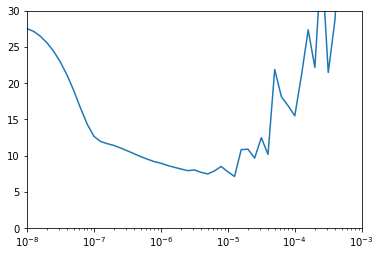

In [8]:
lrs = 1e-8 * (10** (np.arange(100) / 20) )
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-3, 0, 30])

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])
history = model.fit(dataset, epochs=500, verbose=1)

Epoch 1/500
8/8 [==============================] - 2s 211ms/step - loss: 81.1158 - mae: 83.5783
Epoch 2/500
8/8 [==============================] - 0s 59ms/step - loss: 23.6081 - mae: 24.3852
Epoch 3/500
8/8 [==============================] - 1s 64ms/step - loss: 18.2197 - mae: 18.7073
Epoch 4/500
8/8 [==============================] - 0s 57ms/step - loss: 14.1503 - mae: 14.6783
Epoch 5/500
8/8 [==============================] - 0s 58ms/step - loss: 10.7207 - mae: 11.2662
Epoch 6/500
8/8 [==============================] - 0s 52ms/step - loss: 12.5924 - mae: 12.7248
Epoch 7/500
8/8 [==============================] - 1s 65ms/step - loss: 11.9599 - mae: 12.4993
Epoch 8/500
8/8 [==============================] - 0s 58ms/step - loss: 10.1605 - mae: 10.7938
Epoch 9/500
8/8 [==============================] - 0s 60ms/step - loss: 8.1035 - mae: 8.5750
Epoch 10/500
8/8 [==============================] - 0s 50ms/step - loss: 8.0766 - mae: 8.6638
Epoch 11/500
8/8 [==============================] - 

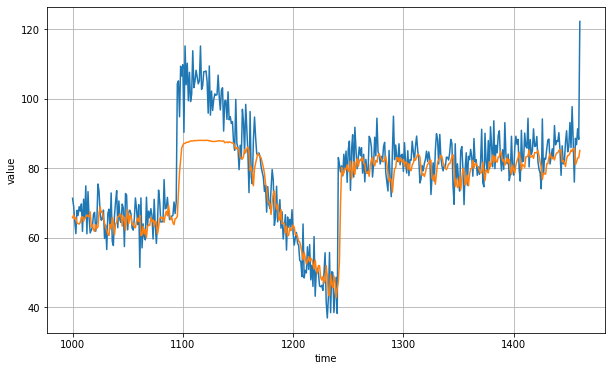

In [10]:
# prediction
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]




plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [12]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.084058

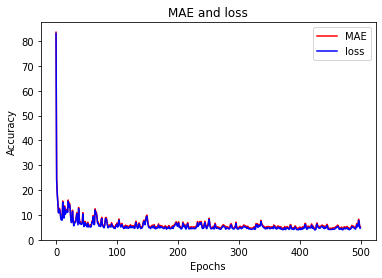

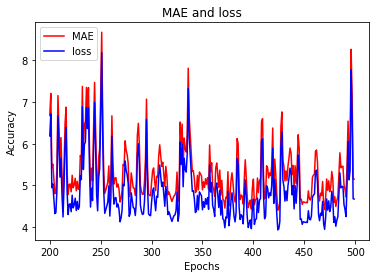

In [11]:
import matplotlib.image as mpimg


mae = history.history['mae']
loss = history.history['loss']

epochs = range(len(loss))


plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['MAE', 'loss'])

plt.figure()
epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['MAE', 'loss'])
plt.show()

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mse'])
history = model.fit(dataset, epochs=500, verbose=1)

Epoch 1/500
8/8 [==============================] - 9s 1s/step - loss: 17.7629 - mse: 531.3893
Epoch 2/500
8/8 [==============================] - 0s 30ms/step - loss: 14.5917 - mse: 323.6322
Epoch 3/500
8/8 [==============================] - 0s 33ms/step - loss: 12.1536 - mse: 255.9852
Epoch 4/500
8/8 [==============================] - 0s 35ms/step - loss: 10.3163 - mse: 197.2308
Epoch 5/500
8/8 [==============================] - 0s 30ms/step - loss: 8.9148 - mse: 162.2713
Epoch 6/500
8/8 [==============================] - 0s 31ms/step - loss: 7.6121 - mse: 130.6350
Epoch 7/500
8/8 [==============================] - 0s 30ms/step - loss: 6.8360 - mse: 109.0071
Epoch 8/500
8/8 [==============================] - 0s 36ms/step - loss: 6.4724 - mse: 96.4795
Epoch 9/500
8/8 [==============================] - 0s 29ms/step - loss: 6.1653 - mse: 88.9878
Epoch 10/500
8/8 [==============================] - 0s 33ms/step - loss: 5.9904 - mse: 84.9667
Epoch 11/500
8/8 [==============================] 

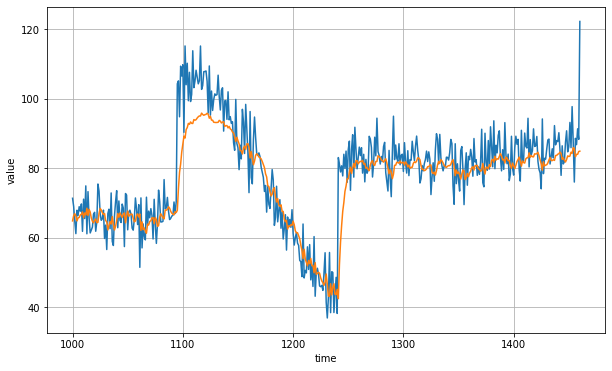

In [14]:
# prediction
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]




plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [15]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.5057044